# Alcohol vs Non-Alcohol Classification (Assignment Report)

**Goal:** Build a classification system that identifies whether a molecule is an alcohol (contains a hydroxyl -OH on an sp3 carbon) using graph-derived features and SELFIES-based encoding for machine learning.

## Objectives
- Create a pseudo dataset of 200 molecules (SMILES + labels).
- Label alcohols using a chemistry-driven SMARTS rule (exclude phenols and carboxylic acids).
- Convert SMILES to SELFIES and build a feature representation.
- Extract graph-derived features from RDKit and combine them with SELFIES features.
- Train multiple ML models and evaluate performance.

## Method overview
1. Generate a balanced, 200-row dataset (100 alcohol, 100 non-alcohol).
2. Validate and canonicalize SMILES with RDKit.
3. Encode each molecule as SELFIES.
4. Vectorize SELFIES tokens and append graph statistics.
5. Train several classifiers and compare results.

In [11]:
%pip install -q numpy pandas scipy scikit-learn matplotlib selfies

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


## Imports and setup
This cell imports the required libraries and fixes the random seed.

In [12]:
import random
import numpy as np
import pandas as pd
from rdkit import Chem
import selfies as sf

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack, csr_matrix

random.seed(42)
np.random.seed(42)

## Dataset construction (200 rows)
We generate candidate SMILES and label them using SMARTS rules.
Alcohol definition used here: an -OH attached to an sp3 carbon (aliphatic alcohol).
We explicitly exclude phenols and carboxylic acids.

In [13]:
ALCOHOL_SMARTS = Chem.MolFromSmarts("[CX4][OX2H]")

ACID_SMARTS = Chem.MolFromSmarts("C(=O)[OX2H]")

PHENOL_SMARTS = Chem.MolFromSmarts("c[OX2H]")



def is_alcohol(mol):

    if mol is None:

        return False

    if mol.HasSubstructMatch(ACID_SMARTS):

        return False

    if mol.HasSubstructMatch(PHENOL_SMARTS):

        return False

    return mol.HasSubstructMatch(ALCOHOL_SMARTS)



def canonical_smiles(smiles):

    mol = Chem.MolFromSmiles(smiles)

    return Chem.MolToSmiles(mol) if mol is not None else None



def linear_alkane(n):

    return "C" * n



def linear_alcohol(n):

    return "C" * n + "O"



def secondary_alcohol(n, pos):

    left = "C" * pos

    right = "C" * (n - pos)

    return left + "(O)" + right



def linear_ether(n, m):

    return ("C" * n) + "O" + ("C" * m)



def linear_ketone(n, pos):

    left = "C" * pos

    right = "C" * (n - pos)

    return left + "(=O)" + right



candidates = set()



# Linear alkanes and alcohols

for n in range(1, 21):

    candidates.add(linear_alkane(n))

    candidates.add(linear_alcohol(n))



# Secondary alcohols and ketones

for n in range(3, 21):

    for pos in range(1, n):

        candidates.add(secondary_alcohol(n, pos))

        candidates.add(linear_ketone(n, pos))



# Ethers

for n in range(1, 9):

    for m in range(1, 9):

        candidates.add(linear_ether(n, m))



acids = ["CC(=O)O", "CCC(=O)O", "CCCC(=O)O", "CC(C)C(=O)O"]

phenols = ["c1ccccc1O", "Oc1ccccc1", "c1ccc(O)cc1"]

specials = ["CC(C)O", "CC(O)C", "CC(C)(C)O", "OCCO", "CC(O)CO", "CC(C)CO", "COC", "CCOC", "CCOCC", "CC(=O)C", "CC=O"]

for smi in acids + phenols + specials:

    candidates.add(smi)



canonical = set()

for smi in candidates:

    canon = canonical_smiles(smi)

    if canon:

        canonical.add(canon)



rows = []

for smi in canonical:

    mol = Chem.MolFromSmiles(smi)

    label = "alcohol" if is_alcohol(mol) else "non-alcohol"

    rows.append({"smiles": smi, "label": label})



df = pd.DataFrame(rows).drop_duplicates(subset=["smiles"])



alcohol_df = df[df["label"] == "alcohol"].sample(frac=1.0, random_state=42)

non_df = df[df["label"] == "non-alcohol"].sample(frac=1.0, random_state=42)



if len(alcohol_df) < 100 or len(non_df) < 100:

    raise ValueError("Not enough candidates to build a 200-row dataset.")



data = pd.concat([alcohol_df.head(100), non_df.head(100)], ignore_index=True)

data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)



data.head(10), data["label"].value_counts()




(                     smiles        label
 0      CCCCCCCCCCC(O)CCCCCC      alcohol
 1   CCCCCCCCCCCCCCCCCCC(C)O      alcohol
 2        CCCCCCCCCCCCC(O)CC      alcohol
 3            CCCCCCCCCCCC=O  non-alcohol
 4  CCCCCCCCCCCCCCC(=O)CCCCC  non-alcohol
 5          CCCCCCCCCC(=O)CC  non-alcohol
 6                   CCCCCCO      alcohol
 7  CCCCCCCCCCCCCCCCC(=O)CCC  non-alcohol
 8  CCCCCCCCCCC(=O)CCCCCCCCC  non-alcohol
 9             CCCCCCCCC(C)O      alcohol,
 label
 alcohol        100
 non-alcohol    100
 Name: count, dtype: int64)

## Save dataset to CSV and reload
We save the generated dataset to a CSV file and read it back to simulate a real data-loading step.

In [14]:
csv_path = "alcohol_non_alcohol_dataset.csv"
data.to_csv(csv_path, index=False)
data = pd.read_csv(csv_path)
data.head(5)

,smiles,label
0,CCCCCCCCCCC(O)CCCCCC,alcohol
1,CCCCCCCCCCCCCCCCCCC(C)O,alcohol
2,CCCCCCCCCCCCC(O)CC,alcohol
3,CCCCCCCCCCCC=O,non-alcohol
4,CCCCCCCCCCCCCCC(=O)CCCCC,non-alcohol


## SELFIES encoding
We encode SMILES into SELFIES and tokenize them. The model is trained on SELFIES tokens, not raw SMILES.

In [15]:
def smiles_to_selfies(smiles):
    return sf.encoder(smiles)

def tokenize_selfies(selfies_str):
    return list(sf.split_selfies(selfies_str))

data["selfies"] = data["smiles"].apply(smiles_to_selfies)
data["selfies_tokens"] = data["selfies"].apply(tokenize_selfies)
data["selfies_joined"] = data["selfies_tokens"].apply(lambda toks: " ".join(toks))

vectorizer = CountVectorizer(token_pattern=r"\[[^\]]+\]")
X_selfies = vectorizer.fit_transform(data["selfies_joined"])

X_selfies.shape

(200, 5)

## Graph-derived features
We compute basic molecular graph statistics and concatenate them with SELFIES features.

In [16]:
def featurize_mol(mol):
    atoms = list(mol.GetAtoms())
    bonds = list(mol.GetBonds())
    degrees = [atom.GetDegree() for atom in atoms]

    hetero_atoms = sum(1 for atom in atoms if atom.GetSymbol() not in ["C", "H"])

    return {
        "num_atoms": len(atoms),
        "num_bonds": len(bonds),
        "mean_degree": float(np.mean(degrees)) if degrees else 0.0,
        "max_degree": float(np.max(degrees)) if degrees else 0.0,
        "min_degree": float(np.min(degrees)) if degrees else 0.0,
        "num_rings": int(mol.GetRingInfo().NumRings()),
        "hetero_atoms": hetero_atoms
    }

mols = [Chem.MolFromSmiles(smi) for smi in data["smiles"]]
graph_features = pd.DataFrame([featurize_mol(mol) for mol in mols])

X_graph = csr_matrix(graph_features.values)
X = hstack([X_selfies, X_graph])

X.shape

(200, 12)

## Train/test split and modeling
We evaluate multiple classifiers on a holdout test set.

In [22]:
y = data["label"].map({"alcohol": 1, "non-alcohol": 0}).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "logistic_regression": Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "svm_linear": Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", SVC(kernel="linear", probability=True))
    ]),
    "naive_bayes": MultinomialNB()
}

reports = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    report = classification_report(y_test, preds, target_names=["non-alcohol", "alcohol"], output_dict=True)
    reports.append({
        "model": name,
        "accuracy": report["accuracy"],
        "f1_alcohol": report["alcohol"]["f1-score"],
        "f1_non_alcohol": report["non-alcohol"]["f1-score"],
        "precision_alcohol": report["alcohol"]["precision"],
        "precision_non_alcohol": report["non-alcohol"]["precision"],
        "recall_alcohol": report["alcohol"]["recall"],
        "recall_non_alcohol": report["non-alcohol"]["recall"]
    })

pd.DataFrame(reports).sort_values("accuracy", ascending=False)

,model,accuracy,f1_alcohol,f1_non_alcohol,precision_alcohol,precision_non_alcohol,recall_alcohol,recall_non_alcohol
1,random_forest,0.875,0.871795,0.878049,0.894737,0.857143,0.85,0.90
3,naive_bayes,0.875,0.888889,0.857143,0.800000,1.000000,1.00,0.75
2,svm_linear,0.850,0.850000,0.850000,0.850000,0.850000,0.85,0.85
0,logistic_regression,0.825,0.837209,0.810811,0.782609,0.882353,0.90,0.75


## Confusion matrix (example model)
We show the confusion matrix for the best-performing model above.

In [18]:
best_model_name = pd.DataFrame(reports).sort_values("accuracy", ascending=False).iloc[0]["model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
best_preds = best_model.predict(X_test)

confusion_matrix(y_test, best_preds)

array([[18,  2],
       [ 3, 17]])

## 5-fold cross-validation
We report cross-validation accuracy to reduce dependence on a single split.

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    cv_results.append({
        "model": name,
        "cv_mean_acc": float(np.mean(scores)),
        "cv_std": float(np.std(scores))
    })

pd.DataFrame(cv_results).sort_values("cv_mean_acc", ascending=False)

,model,cv_mean_acc,cv_std
0,logistic_regression,0.905,0.024495
2,svm_linear,0.895,0.040000
1,random_forest,0.885,0.020000
3,naive_bayes,0.870,0.018708


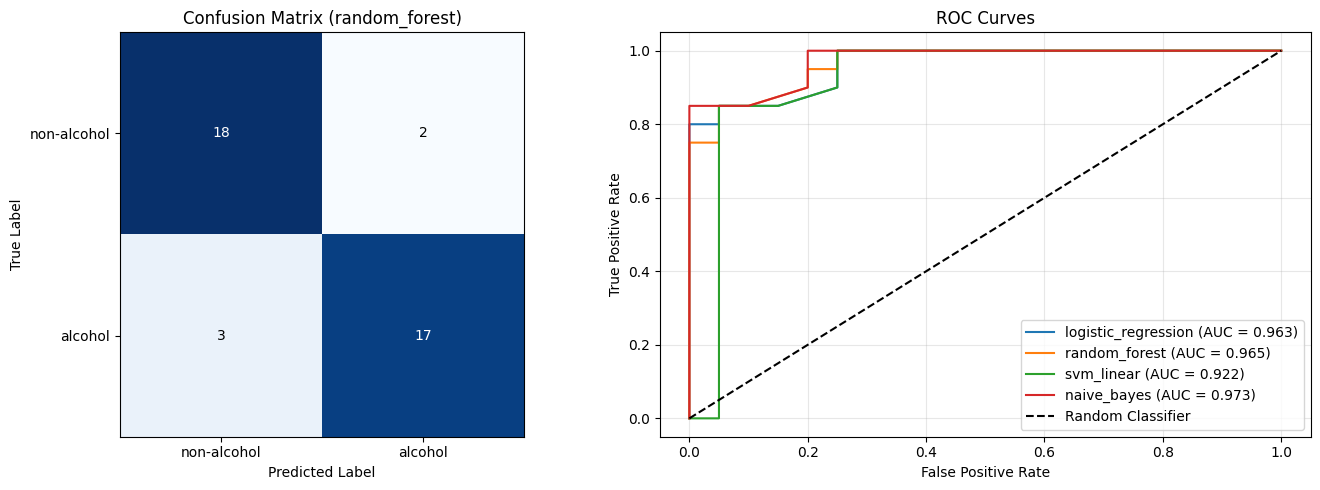

In [20]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

import matplotlib.pyplot as plt

# Confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, best_preds)
axes[0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0].set_title(f'Confusion Matrix ({best_model_name})')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['non-alcohol', 'alcohol'])
axes[0].set_yticklabels(['non-alcohol', 'alcohol'])

# Add counts to confusion matrix
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

# ROC curves for all models
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()